In [1]:
%run "E:\Users\puzheng\Documents\Startup_py3.py"
sys.path.append(r"E:\Users\puzheng\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

15832


# 0. required packages for h5py

In [2]:
import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)

reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH',
             'save_folder':r'D:\Pu_Temp\20201002_IgH_proB_iaa_dox+',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20201012-Corrections_2color',
             'shared_parameters':{
                     'single_im_size':[35,2048,2048],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'min_num_seeds':500,
                     'max_num_seeds': 2500,
                     'spot_seeding_th':125,
                     'normalize_intensity_local':True,
                     'normalize_intensity_background':False,
                 },             
             }

fov_ids = np.arange(3,23)

In [4]:
reload(io_tools.load)
from ImageAnalysis3.spot_tools.picking import assign_spots_to_chromosomes
overwrite=False
intensity_th = 0.5

spots_list_list = []
chrom_coords_list = []
cand_chr_spots_list = []

for _fov_id in fov_ids:

    # create fov class
    fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                              _color_info_kwargs={
                                                  '_color_filename':'Color_Usage',
                                              }, 
                                              _prioritize_saved_attrs=False,
                                              )

    # process image into spots
    id_list, spot_list = fov._process_image_to_spots('unique', 
                                                     _load_common_reference=True,
                                                     _load_with_multiple=False,
                                                     _save_images=True,
                                                     _warp_images=False, 
                                                     _overwrite_drift=False,
                                                     _overwrite_image=False,
                                                     _overwrite_spot=overwrite,
                                                     _verbose=True)
    # identify chromosomes
    chrom_im = fov._load_chromosome_image(_overwrite=overwrite)
    chrom_coords = fov._find_candidate_chromosomes_by_segmentation(_filt_size=4,
                                                                   _binary_per_th=99.7, 
                                                                   _morphology_size=2,
                                                                   _overwrite=overwrite)
    fov._load_from_file('unique')
    chrom_coords = fov._select_chromosome_by_candidate_spots(_good_chr_loss_th=0.15,
                                                             _cand_spot_intensity_th=0.75,
                                                             _save=True, 
                                                             _overwrite=overwrite)
    # append
    spots_list_list.append(fov.unique_spots_list)
    chrom_coords_list.append(fov.chrom_coords)
    
    fov_cand_chr_spots_list = [[] for _ct in fov.chrom_coords]

    # finalize candidate spots
    for _spots in fov.unique_spots_list:
        _cands_list = assign_spots_to_chromosomes(_spots, fov.chrom_coords)
        for _i, _cands in enumerate(_cands_list):
            fov_cand_chr_spots_list[_i].append(_cands)
            
    cand_chr_spots_list += fov_cand_chr_spots_list
    
    print(f"kept chromosomes: {len(fov.chrom_coords)}")

# combine acquired spots and chromosomes
chrom_coords = np.concatenate(chrom_coords_list)

from ImageAnalysis3.spot_tools.picking import convert_spots_to_hzxys
dna_cand_hzxys_list = [convert_spots_to_hzxys(_spots, fov.shared_parameters['distance_zxy'])
                       for _spots in cand_chr_spots_list]
dna_reg_ids = fov.unique_ids

print(f"{len(chrom_coords)} are found.")

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 1.358s.
+ loading correction from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_03.hdf5


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1408: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


++ finish loading unique in 0.024s. 
+ directly use current chromsome coordinates.
kept chromosomes: 101
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_04.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 1.059s.
+ loading correction from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_04.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly f

-- checking unique, region:[391 386] in 0.003s.
-- checking unique, region:[394 389] in 0.003s.
-- checking unique, region:[ 43 392] in 0.004s.
-- checking unique, region:[ 49 395] in 0.004s.
-- checking unique, region:[55 46] in 0.005s.
-- checking unique, region:[62 52] in 0.004s.
-- checking unique, region:[68 59] in 0.003s.
-- checking unique, region:[74 65] in 0.004s.
-- checking unique, region:[80 71] in 0.004s.
-- checking unique, region:[86 77] in 0.004s.
-- checking unique, region:[92 83] in 0.003s.
-- checking unique, region:[98 89] in 0.003s.
-- checking unique, region:[104  95] in 0.004s.
-- checking unique, region:[110 101] in 0.003s.
-- checking unique, region:[325 107] in 0.004s.
-- checking unique, region:[331 113] in 0.004s.
-- checking unique, region:[341 328] in 0.004s.
-- checking unique, region:[347 334] in 0.003s.
-- checking unique, region:[353 344] in 0.004s.
-- checking unique, region:[359 350] in 0.004s.
-- checking unique, region:[365 356] in 0.004s.
-- check

-- checking unique, region:[41 42] in 0.007s.
-- checking unique, region:[44 45] in 0.004s.
-- checking unique, region:[47 48] in 0.004s.
-- checking unique, region:[50 51] in 0.004s.
-- checking unique, region:[53 54] in 0.003s.
-- checking unique, region:[56 57] in 0.004s.
-- checking unique, region:[60 61] in 0.003s.
-- checking unique, region:[63 64] in 0.004s.
-- checking unique, region:[66 67] in 0.004s.
-- checking unique, region:[69 70] in 0.003s.
-- checking unique, region:[72 73] in 0.004s.
-- checking unique, region:[75 76] in 0.003s.
-- checking unique, region:[78 79] in 0.004s.
-- checking unique, region:[81 82] in 0.003s.
-- checking unique, region:[84 85] in 0.004s.
-- checking unique, region:[87 88] in 0.004s.
-- checking unique, region:[90 91] in 0.003s.
-- checking unique, region:[93 94] in 0.004s.
-- checking unique, region:[96 97] in 0.004s.
-- checking unique, region:[ 99 100] in 0.003s.
-- checking unique, region:[102 103] in 0.004s.
-- checking unique, region:[10

kept chromosomes: 131
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_09.hdf5
++ base attributes loaded:['cand_chrom_coords', 'chrom_coords', 'chrom_im', 'ref_im'] in 2.267s.
+ loading correction from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_09.hdf5
++ load bleed correction profile directly from savefile.
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illumination correction profile directly from savefile.
+ loading segmentation from file: D:\Pu_Temp\20201002_IgH_proB_iaa_do

-- checking unique, region:[ 49 395] in 0.003s.
-- checking unique, region:[55 46] in 0.003s.
-- checking unique, region:[62 52] in 0.004s.
-- checking unique, region:[68 59] in 0.003s.
-- checking unique, region:[74 65] in 0.004s.
-- checking unique, region:[80 71] in 0.003s.
-- checking unique, region:[86 77] in 0.004s.
-- checking unique, region:[92 83] in 0.004s.
-- checking unique, region:[98 89] in 0.004s.
-- checking unique, region:[104  95] in 0.003s.
-- checking unique, region:[110 101] in 0.004s.
-- checking unique, region:[325 107] in 0.004s.
-- checking unique, region:[331 113] in 0.004s.
-- checking unique, region:[341 328] in 0.004s.
-- checking unique, region:[347 334] in 0.004s.
-- checking unique, region:[353 344] in 0.003s.
-- checking unique, region:[359 350] in 0.004s.
-- checking unique, region:[365 356] in 0.004s.
-- checking unique, region:[371 362] in 0.003s.
-- checking unique, region:[377 368] in 0.004s.
-- checking unique, region:[384 374] in 0.003s.
-- check

-- checking unique, region:[41 42] in 0.005s.
-- checking unique, region:[44 45] in 0.004s.
-- checking unique, region:[47 48] in 0.004s.
-- checking unique, region:[50 51] in 0.004s.
-- checking unique, region:[53 54] in 0.003s.
-- checking unique, region:[56 57] in 0.004s.
-- checking unique, region:[60 61] in 0.004s.
-- checking unique, region:[63 64] in 0.004s.
-- checking unique, region:[66 67] in 0.003s.
-- checking unique, region:[69 70] in 0.004s.
-- checking unique, region:[72 73] in 0.004s.
-- checking unique, region:[75 76] in 0.003s.
-- checking unique, region:[78 79] in 0.003s.
-- checking unique, region:[81 82] in 0.004s.
-- checking unique, region:[84 85] in 0.003s.
-- checking unique, region:[87 88] in 0.003s.
-- checking unique, region:[90 91] in 0.003s.
-- checking unique, region:[93 94] in 0.003s.
-- checking unique, region:[96 97] in 0.003s.
-- checking unique, region:[ 99 100] in 0.004s.
-- checking unique, region:[102 103] in 0.003s.
-- checking unique, region:[10

-- illumination correction for channels: 488, in 1.114s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 19.726s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_13.hdf5
++ base attributes saved:['ref_im'] in 3.132s.
-- checking unique, region:[41 42] in 0.003s.
-- checking unique, region:[44 45] in 0.002s.
-- checking unique, region:[47 48] in 0.002s.
-- checking unique, region:[50 51] in 0.003s.
-- checking unique, region:[53 54] in 0.002s.
-- checking unique, region:[56 57] in 0.003s.
-- checking unique, region:[60 61] in 0.002s.
-- checking unique, region:[63 64] in 0.003s.
-- checking unique, region:[66 67] in 0.002s.
-- checking unique, region:[69 70] in 0.003s.
-- checking unique, region:[72 73] in 0.002s.
-- checking unique, region:[75 76] in 0.003s.
-- checking unique, region:[78 79] in 0.002s.
-- checking unique, region:[81 82] in 0.003s.
-- checking unique, region:[84 85] in 0.002s.
-- checking unique, re

E:\Users\puzheng\Documents\ImageAnalysis3\segmentation_tools\chromosome.py:79: UserWarning: Random walker only segments unlabeled areas, where labels == 0. No zero valued areas in labels were found. Returning provided labels.
  _seg_label = random_walker(adj_chrom_im, _label, beta=10, mode='cg_mg')


-- find objects larger than size=50
-- 214 objects are found by segmentation.
- Start multiprocessing caluclate chromosome coordinates with 16 threads in 132.712s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_13.hdf5
++ base attributes saved:['cand_chrom_coords'] in 0.023s.
+ loading unique from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_13.hdf5
++ finish loading unique in 0.072s. 
+ loading fov_info from file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_13.hdf5
++ base attributes loaded:[] in 0.760s.
- start select from 214 chromosomes with loss threshold=0.15
-- remove chr id 65, percentage of lost rounds:0.833.
-- remove chr id 68, percentage of lost rounds:0.757.
-- remove chr id 184, percentage of lost rounds:0.750.
-- remove chr id 203, percentage of lost rounds:0.521.
-- remove chr id 87, percentage of lost rounds:0.500.
-- remove chr id 13, percentage of lost rounds:0.472.
-- remove chr id 33, percentage of lost rounds:0.444.
-- 

-- checking unique, region:[47 48] in 0.003s.
-- checking unique, region:[50 51] in 0.003s.
-- checking unique, region:[53 54] in 0.003s.
-- checking unique, region:[56 57] in 0.003s.
-- checking unique, region:[60 61] in 0.003s.
-- checking unique, region:[63 64] in 0.003s.
-- checking unique, region:[66 67] in 0.003s.
-- checking unique, region:[69 70] in 0.004s.
-- checking unique, region:[72 73] in 0.003s.
-- checking unique, region:[75 76] in 0.003s.
-- checking unique, region:[78 79] in 0.003s.
-- checking unique, region:[81 82] in 0.004s.
-- checking unique, region:[84 85] in 0.004s.
-- checking unique, region:[87 88] in 0.004s.
-- checking unique, region:[90 91] in 0.004s.
-- checking unique, region:[93 94] in 0.004s.
-- checking unique, region:[96 97] in 0.003s.
-- checking unique, region:[ 99 100] in 0.004s.
-- checking unique, region:[102 103] in 0.004s.
-- checking unique, region:[105 106] in 0.003s.
-- checking unique, region:[108 109] in 0.003s.
-- checking unique, region

++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
++ load chromatic_constants correction profile from original file.
-- loading chromatic_constants correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048_const.pkl
	 647 None
++ load illumination correction profile from original file.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 647 illumination_correction_647_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
- Creating save file for fov:Conv_zscan_15.dax: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_15.hdf5.
* create savefile: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_15.hdf5
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_15.hdf5
++ base attributes saved:['analysis_folder', 'annotated_fol

 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3357.94s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_15.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profile from file:
	 750 chromatic_correction_750_647_35_2048_2048.npy
	 647 None
-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_15.dax  in 13.246s
-- removing hot pixels for channels:['750'] in 6.929s
-- illumination correction for channels: 750, in 1.418s
-- warp image with chromatic correction for channels: ['750'] and drift:[0. 0. 0.] 750, in 69.219s
-- finish correction in 114.389s
-- chromosome image has drift: [0. 0. 0.]
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_15.hdf5
++ base attributes saved:['chrom_im

-- loading image from file:\\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_16.dax  in 13.532s
-- removing hot pixels for channels:['488'] in 6.206s
-- illumination correction for channels: 488, in 1.599s
-- -- generate translation function with drift:[0. 0. 0.] in 0.000s
-- finish correction in 21.642s
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5
++ base attributes saved:['ref_im'] in 3.607s.
-- checking unique, region:[41 42] in 0.004s.
-- checking unique, region:[44 45] in 0.003s.
-- checking unique, region:[47 48] in 0.003s.
-- checking unique, region:[50 51] in 0.003s.
-- checking unique, region:[53 54] in 0.003s.
-- checking unique, region:[56 57] in 0.003s.
-- checking unique, region:[60 61] in 0.003s.
-- checking unique, region:[63 64] in 0.002s.
-- checking unique, region:[66 67] in 0.002s.
-- checking unique, region:[69 70] in 0.003s.
-- checking unique, region:[72 73] in 0.004s.
-- checking unique, reg

-- remove chr id 51, percentage of lost rounds:0.167.
-- remove chr id 23, percentage of lost rounds:0.160.
-- remove chr id 91, percentage of lost rounds:0.160.
-- 144 chromosomes are kept.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_16.hdf5
++ base attributes saved:['chrom_coords'] in 0.134s.
kept chromosomes: 144
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- Hyb H0R0 exists in this data
-- DAPI exists in hyb: H0R0
- 73 folders are found according to color-usage annotation.
++ load bleed correction profile from original file.
-- loading bleedthrough correction profile from file:bleedthrough_correction_750_647_2048_2048.npy
++ load chromatic correction profile from original file.
-- loading chromatic correction profile from file:
	 750 

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3599.58s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_17.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

-- saving 750_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5.
-- saving 647_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5.
-- 647_chromatic_constants profile already exist in save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5, skip.
-- saving 750_647_bleed profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5.
-- saving unique to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.025s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_18.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_

-- remove chr id 59, percentage of lost rounds:0.778.
-- remove chr id 140, percentage of lost rounds:0.750.
-- remove chr id 159, percentage of lost rounds:0.715.
-- remove chr id 114, percentage of lost rounds:0.667.
-- remove chr id 17, percentage of lost rounds:0.632.
-- remove chr id 0, percentage of lost rounds:0.611.
-- remove chr id 80, percentage of lost rounds:0.604.
-- remove chr id 178, percentage of lost rounds:0.604.
-- remove chr id 27, percentage of lost rounds:0.597.
-- remove chr id 6, percentage of lost rounds:0.549.
-- remove chr id 43, percentage of lost rounds:0.549.
-- remove chr id 151, percentage of lost rounds:0.542.
-- remove chr id 95, percentage of lost rounds:0.507.
-- remove chr id 124, percentage of lost rounds:0.507.
-- remove chr id 19, percentage of lost rounds:0.500.
-- remove chr id 58, percentage of lost rounds:0.472.
-- remove chr id 155, percentage of lost rounds:0.472.
-- remove chr id 166, percentage of lost rounds:0.465.
-- remove chr id 5, pe

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3233.92s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_19.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

-- saving 750_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5.
-- saving 647_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5.
-- 647_chromatic_constants profile already exist in save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5, skip.
-- saving 750_647_bleed profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5.
-- saving unique to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.011s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_20.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_

-- remove chr id 282, percentage of lost rounds:0.785.
-- remove chr id 8, percentage of lost rounds:0.736.
-- remove chr id 300, percentage of lost rounds:0.660.
-- remove chr id 265, percentage of lost rounds:0.639.
-- remove chr id 169, percentage of lost rounds:0.625.
-- remove chr id 176, percentage of lost rounds:0.618.
-- remove chr id 125, percentage of lost rounds:0.562.
-- remove chr id 296, percentage of lost rounds:0.562.
-- remove chr id 149, percentage of lost rounds:0.556.
-- remove chr id 97, percentage of lost rounds:0.535.
-- remove chr id 292, percentage of lost rounds:0.507.
-- remove chr id 261, percentage of lost rounds:0.472.
-- remove chr id 60, percentage of lost rounds:0.451.
-- remove chr id 221, percentage of lost rounds:0.431.
-- remove chr id 268, percentage of lost rounds:0.410.
-- remove chr id 165, percentage of lost rounds:0.396.
-- remove chr id 220, percentage of lost rounds:0.382.
-- remove chr id 18, percentage of lost rounds:0.347.
-- remove chr i

-- saving 750_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5.
-- saving 647_chromatic profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5.
-- saving 750_chromatic_constants profile with ['fitting_orders', 'constants', 'rsquares', 'ref_center'] to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5.
-- 647_chromatic_constants profile already exist in save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5, skip.
-- saving 750_647_bleed profile to save_file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5.
-- saving unique to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5
--- unique attributes updated:['ids', 'channels', 'ims', 'spots', 'drifts', 'flags'] in 0.003s.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5
++ base attributes saved:['analysis_folder', 'annotated_folders', 'bead_channel_index', 'channels', 'color_dic', 'color_

-- remove chr id 213, percentage of lost rounds:0.743.
-- remove chr id 212, percentage of lost rounds:0.694.
-- remove chr id 113, percentage of lost rounds:0.646.
-- remove chr id 49, percentage of lost rounds:0.618.
-- remove chr id 181, percentage of lost rounds:0.618.
-- remove chr id 2, percentage of lost rounds:0.597.
-- remove chr id 237, percentage of lost rounds:0.597.
-- remove chr id 137, percentage of lost rounds:0.583.
-- remove chr id 21, percentage of lost rounds:0.576.
-- remove chr id 3, percentage of lost rounds:0.569.
-- remove chr id 38, percentage of lost rounds:0.562.
-- remove chr id 13, percentage of lost rounds:0.542.
-- remove chr id 303, percentage of lost rounds:0.535.
-- remove chr id 231, percentage of lost rounds:0.521.
-- remove chr id 29, percentage of lost rounds:0.486.
-- remove chr id 126, percentage of lost rounds:0.486.
-- remove chr id 43, percentage of lost rounds:0.479.
-- remove chr id 181, percentage of lost rounds:0.479.
-- remove chr id 54,

-- remove chr id 48, percentage of lost rounds:0.167.
-- remove chr id 101, percentage of lost rounds:0.167.
-- remove chr id 161, percentage of lost rounds:0.167.
-- remove chr id 187, percentage of lost rounds:0.167.
-- remove chr id 195, percentage of lost rounds:0.167.
-- remove chr id 28, percentage of lost rounds:0.160.
-- remove chr id 125, percentage of lost rounds:0.160.
-- remove chr id 1, percentage of lost rounds:0.153.
-- remove chr id 33, percentage of lost rounds:0.153.
-- remove chr id 45, percentage of lost rounds:0.153.
-- 200 chromosomes are kept.
-- saving fov_info to file: D:\Pu_Temp\20201002_IgH_proB_iaa_dox+\Conv_zscan_21.hdf5
++ base attributes saved:['chrom_coords'] in 0.105s.
kept chromosomes: 200
Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 83
- Number of field of views: 64
- Importing csv file: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
-- H

+ Start multi-processing of pre-processing for 72 images with 16 threads
++ processed unique ids: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 321 323 324 325 326 327 328 329 330 331 332 333 334 335 337 339
 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357
 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375
 376 377 379 380 381 382 383 384 386 387 388 389 390 391 392 393 394 395] in 3389.86s.
-- choose chrom images from folder: \.
- correct the whole fov for image: \\10.245.74.158\Chromatin_NAS_6\20201002-B_dox-IAA-STI+_CTP-08_IgH\H0R0\Conv_zscan_22.dax
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
-- loading chromatic correction profil

In [5]:
# select_hzxys close to the chromosome center
dist_th = 3000 # upper limit is 5000nm
intensity_th = 0.5
sel_dna_cand_hzxys_list = []
for _cand_hzxys, _chrom_coord in zip(dna_cand_hzxys_list, chrom_coords):
    _sel_cands_list = []
    
    for _cands in _cand_hzxys:
        if len(_cands) == 0:
            _sel_cands_list.append([])
        else:
            _dists = np.linalg.norm(_cands[:,1:4] - _chrom_coord*np.array([200,108,108]), axis=1)
            _sel_cands_list.append(_cands[(_dists < dist_th) & (_cands[:,0]>=intensity_th)])
            
    # append
    sel_dna_cand_hzxys_list.append(_sel_cands_list)

### EM pick spots

- iter:0
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 21.017s
-- collapse all regions into 1d.


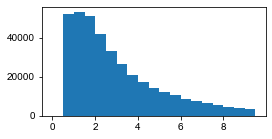

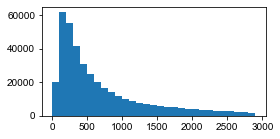

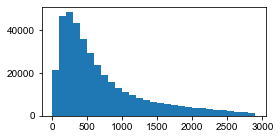

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 20.887s
-- region kept: 0.8523
- iter:1
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 15.578s
-- collapse all regions into 1d.


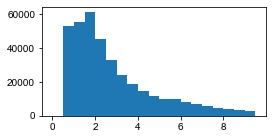

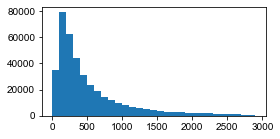

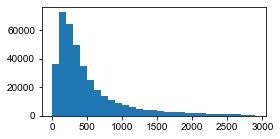

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 20.768s
-- region kept: 0.9334
- iter:2
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 16.093s
-- collapse all regions into 1d.


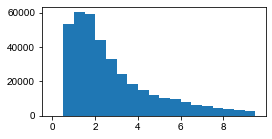

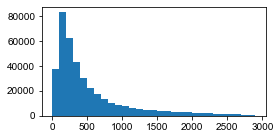

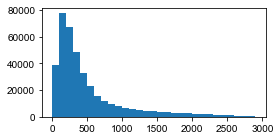

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 20.788s
-- region kept: 0.9796
- iter:3
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 15.679s
-- collapse all regions into 1d.


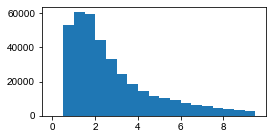

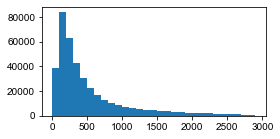

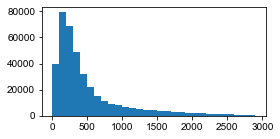

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 20.677s
-- region kept: 0.9920
- iter:4
- generate reference metrics from picked chrs.
-- multiprocessing process references with 12 threads, in 15.886s
-- collapse all regions into 1d.


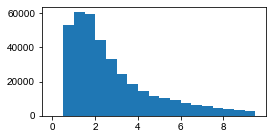

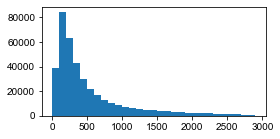

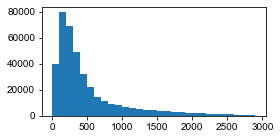

- start EM picking.
-- directly use given reference.
-- multiprocessing maximization step with 12 threads, in 20.801s
-- region kept: 0.9957


In [6]:
# load functions
reload(ia.spot_tools.picking)
from ImageAnalysis3.spot_tools.picking import Pick_spots_by_intensity, EM_pick_scores_in_population, generate_reference_from_population,evaluate_differences

%matplotlib inline
niter= 10
nkeep = len(sel_dna_cand_hzxys_list)
num_threads = 12
# initialize
init_dna_hzxys = Pick_spots_by_intensity(sel_dna_cand_hzxys_list[:nkeep])
# set save list
sel_dna_hzxys_list, sel_dna_scores_list, all_dna_scores_list = [init_dna_hzxys], [], []
for _iter in range(niter):
    print(f"- iter:{_iter}")
    # generate reference
    ref_ct_dists, ref_local_dists, ref_ints = generate_reference_from_population(
        sel_dna_hzxys_list[-1], dna_reg_ids, 
        sel_dna_hzxys_list[-1][:nkeep], dna_reg_ids,
        num_threads=num_threads,
        collapse_regions=True,
    )
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ints), bins=np.arange(0,10,0.5))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_ct_dists), bins=np.arange(0,3000,100))
    plt.figure(figsize=(4,2))
    plt.hist(np.ravel(ref_local_dists), bins=np.arange(0,3000,100))
    plt.show()
    # scoring
    sel_hzxys, sel_scores, all_scores = EM_pick_scores_in_population(
            sel_dna_cand_hzxys_list[:nkeep], dna_reg_ids, sel_dna_hzxys_list[-1], 
            ref_ct_dists, ref_local_dists, ref_ints,
            sel_dna_hzxys_list[-1], dna_reg_ids, num_threads=num_threads,
        )
    update_rate = evaluate_differences(sel_hzxys, sel_dna_hzxys_list[-1])
    print(f"-- region kept: {update_rate:.4f}")
    sel_dna_hzxys_list.append(sel_hzxys)
    sel_dna_scores_list.append(sel_scores)
    all_dna_scores_list.append(all_scores)
    
    if update_rate > 0.995:
        break

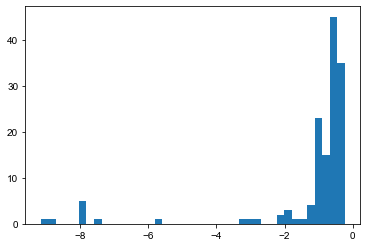

In [16]:
plt.figure()
plt.hist(np.log(sel_dna_scores_list[sel_iter][1]), 40)
plt.show()

In [7]:
from scipy.spatial.distance import pdist, squareform
sel_iter = -1

final_dna_hzxys_list = []
distmap_list = []
score_th = np.exp(-3)
bad_spot_percentage = 0.6
for _hzxys, _scores in zip(sel_dna_hzxys_list[sel_iter], sel_dna_scores_list[sel_iter]):
    _kept_hzxys = np.array(_hzxys).copy()
    _kept_hzxys[_scores < score_th] = np.nan
    if np.mean(np.isnan(_kept_hzxys).sum(1)>0)<bad_spot_percentage:
        final_dna_hzxys_list.append(_kept_hzxys)
        distmap_list.append(squareform(pdist(_kept_hzxys[:,1:4])))

distmap_list = np.array(distmap_list)
median_distmap = np.nanmedian(distmap_list, axis=0)

0.2219351389878831


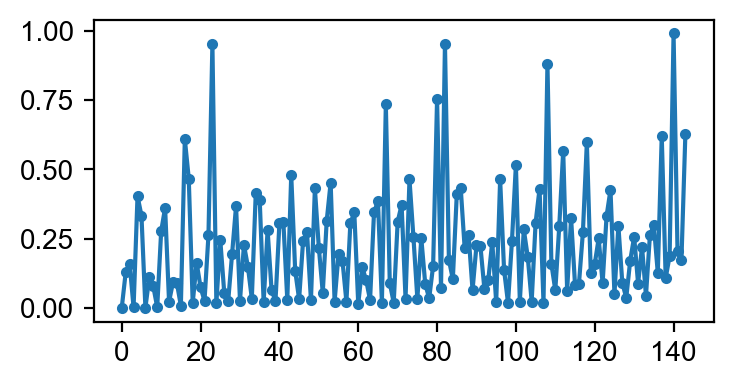

In [8]:
loss_rates = np.mean(np.sum(np.isnan(final_dna_hzxys_list), axis=2)>0, axis=0)
print(np.mean(loss_rates))
fig, ax = plt.subplots(figsize=(4,2),dpi=200)
ax.plot(loss_rates, '.-')
ax.set_xticks(np.arange(0,150,20))
plt.show()

In [9]:
len(chrom_coords)

2811

In [13]:
kept_inds = np.where(loss_rates<0.25)[0]

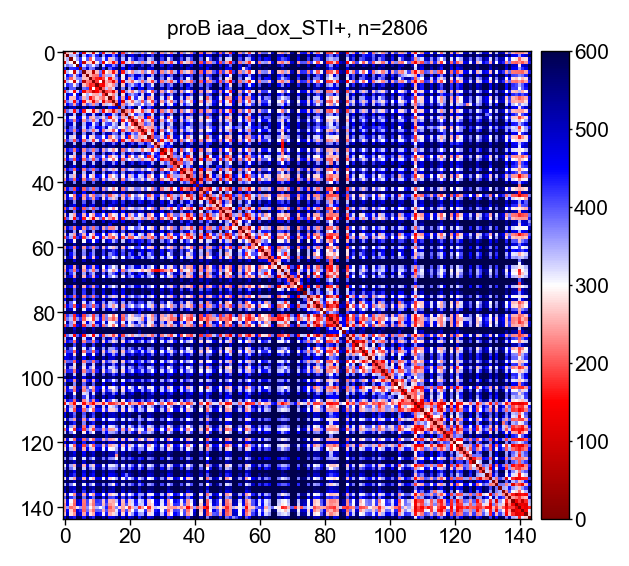

In [14]:
fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(median_distmap,
                                               #median_distmap[kept_inds][:,kept_inds], 
                                               color_limits=[0,600],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB iaa_dox_STI+, n={len(distmap_list)}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

## visualize single example

<IPython.core.display.Javascript object>


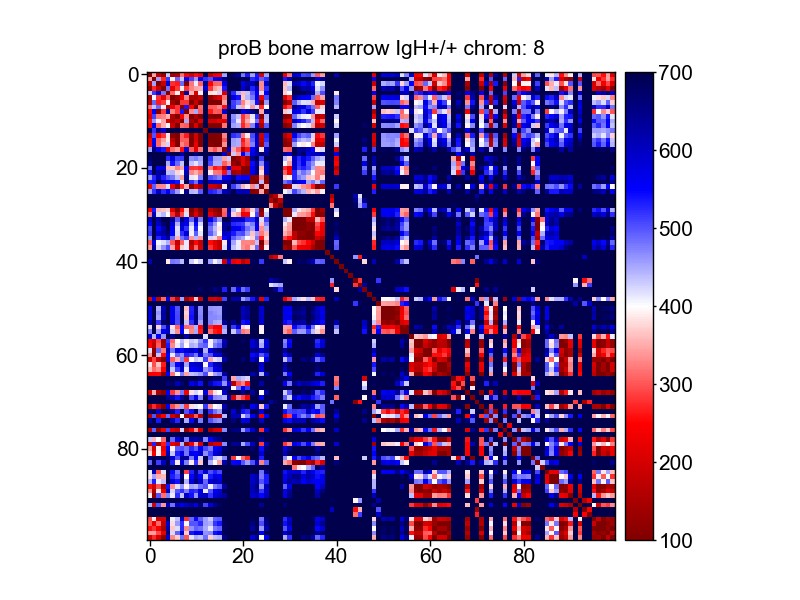

<IPython.core.display.Javascript object>


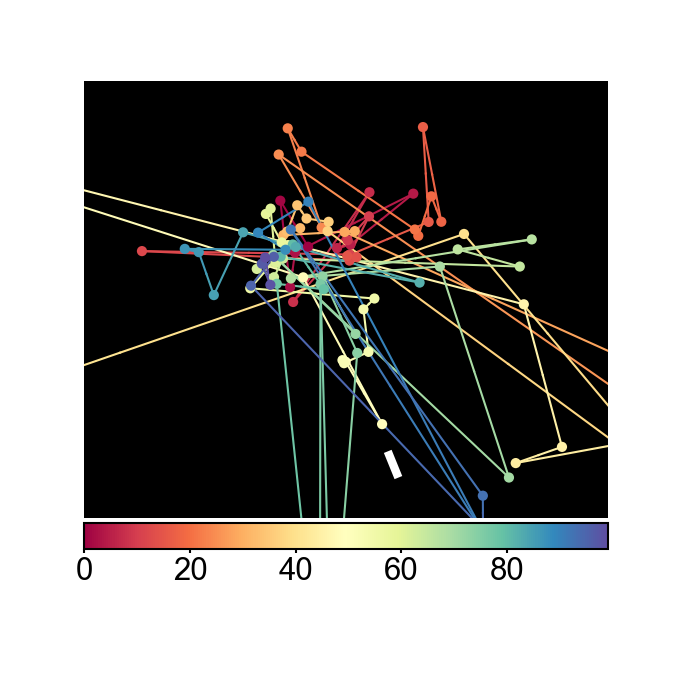

-- add colorbar with colornorm: <matplotlib.colors.Normalize object at 0x000001E7E1C3A940>


In [15]:
%matplotlib notebook
chrom_id = 8

valid_inds = np.where(np.isnan(final_dna_hzxys_list[chrom_id]).sum(1) == 0)[0]

fig, ax = plt.subplots(figsize=(4,3),dpi=200)
ax = ia.figure_tools.distmap.plot_distance_map(#distmap_list[chrom_id],
                                               distmap_list[chrom_id][valid_inds][:,valid_inds], 
                                               color_limits=[100,700],
                                               ax=ax,
                                               ticks=np.arange(0,150,20), 
                                               figure_dpi=200)
ax.set_title(f"proB bone marrow IgH+/+ chrom: {chrom_id}", fontsize=7.5)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()



reload(figure_tools.image)
ax3d = figure_tools.image.chromosome_structure_3d_rendering(#final_dna_hzxys_list[chrom_id][:,1:], 
                                                     final_dna_hzxys_list[chrom_id][valid_inds, 1:], 
                                                     marker_edge_line_width=0,
                                                     reference_bar_length=100, image_radius=400, 
                                                     line_width=0.5, figure_dpi=300, depthshade=False)
plt.show()

## save matrix

In [16]:
output_folder = r'\\10.245.74.158\Chromatin_NAS_6\20201031-processed_matrix'

np.save(os.path.join(output_folder, '20201002_proB_dox+'), distmap_list)